# Tải và Import các thư viện cần thiết

In [ ]:
!pip install tensorflow keras pillow numpy tqdm underthesea gensim fasttext nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 KB 43.0 MB/s eta 0:00:00
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp39-cp39-linux_x86_64.whl size=4395840 sha256=3c6986f2895b474c4ae5ee3c42592295fd97651f3f5aab0ada5a8b1ae9b850d6
  Stored in directory: /root/.cache/pip/wheels/64/57/bc/1741406019061d5664914b070bd3e71f6244648732bc96109e
Successfully built fasttext


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import os
import sys
import string
import fasttext
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump, load
from underthesea import word_tokenize
from gensim.utils import simple_preprocess

from keras.preprocessing.text import Tokenizer
from keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences

# from keras.applications.xception import Xception, preprocess_input
import keras.utils as image
from keras.layers import (Input, Dense, LSTM, Embedding, Dropout, Bidirectional, add, Layer, MultiHeadAttention,
                          LayerNormalization, Flatten, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D, concatenate)
from keras.initializers import Constant
from keras.models import Model, load_model
from keras.utils.vis_utils import plot_model
from keras.regularizers import l2

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from tqdm.notebook import tqdm
from nltk.translate.bleu_score import corpus_bleu

# Tiền xử lý dữ liệu

In [ ]:
image_dir = '/content/drive/MyDrive/Deep learning/Midterm/Data/Images/'
text_file = '/content/drive/MyDrive/Deep learning/Midterm/Data/captions_vi.txt'
train_image_dir = '/content/drive/MyDrive/Deep learning/Midterm/Data/trainImgaes.txt'
test_image_dir = '/content/drive/MyDrive/Deep learning/Midterm/Data/testImages.txt'
embedding_model_dir = '/content/drive/MyDrive/Deep learning/Midterm/Data/cc.vi.300.bin'

In [ ]:
def load_doc(filename):
  file = open(filename, 'r', encoding='utf-8')
  text = file.read()
  file.close()
  return text

In [ ]:
def all_img_captions(filename):
  file = load_doc(filename)
  captions = file.split('\n')
  descriptions = dict()
  for caption in captions[:-1]:
      img, cap = caption.split('\t')
      if img not in descriptions:
          descriptions[img] = [cap]
      else:
          descriptions[img].append(cap)
  return descriptions

In [ ]:
def cleaning_text(descriptions):
  table = str.maketrans('', '', string.punctuation)
  for img, captions in descriptions.items():
      for idx, cap in enumerate(captions):
          desc = cap.replace(' - ', ' ').translate(table)
          desc = ' '.join(simple_preprocess(desc))
          desc = word_tokenize(desc, format='text')

          descriptions[img][idx] = desc
  return descriptions

In [ ]:
def text_vocabulary(descriptions):
  vocab = set()
  for key in descriptions.keys():
      [vocab.update(desc.split()) for desc in descriptions[key]]
  return vocab

In [ ]:
def save_descriptions(descriptions, filename):
  lines = list()
  for key, captions in descriptions.items():
      for cap in captions:
          lines.append(key + '\t' + cap)
  data = '\n'.join(lines)
  file = open(filename, 'w', encoding='utf-8')
  file.write(data)
  file.close()

In [ ]:
sample_image = '2423292784_166ee54e0b.jpg'
descriptions = all_img_captions(text_file)
print('Length of descriptions:', len(descriptions))
print('Description before clean text')
descriptions[sample_image]

Length of descriptions: 8000
Description before clean text


['Một cậu bé với một cái chao kim loại trên đầu ',
 ' Một chú hề nhỏ với chiếc chao trên đầu',
 ' Một cậu bé điên có một cái bát trên đầu',
 ' Một cậu bé đội một chiếc chao kim loại trên đầu',
 ' Cậu bé mặc áo sơ mi sọc này đang đặt một cái rây trên đầu']

In [ ]:
clean_descriptions = cleaning_text(descriptions)
print('Descriptions after clean text')
clean_descriptions[sample_image]

Descriptions after clean text


['một cậu bé với một cái chao kim_loại trên đầu',
 'một chú hề nhỏ với chiếc chao trên đầu',
 'một cậu bé điên có một cái bát trên đầu',
 'một cậu bé đội một chiếc chao kim_loại trên đầu',
 'cậu bé mặc áo sơ_mi sọc này đang đặt một cái rây trên đầu']

In [ ]:
vocab = text_vocabulary(clean_descriptions)
print('Length of vocabuary:', len(vocab))

Length of vocabuary: 5562


In [ ]:
save_descriptions(clean_descriptions, 'descriptions.txt')

# Trích xuất đặc trưng từ ảnh

In [ ]:
def extract_features(directory):
  model = ResNet50(weights='imagenet')
  model = Model(model.input, model.layers[-2].output)

  features = dict()
  for img in tqdm(os.listdir(directory), file=sys.stdout):
    filename = directory + '/' + img
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)

    feature = model.predict(image, verbose=0)
    features[img] = feature
  return features

In [ ]:
#features = extract_features(image_dir)

In [ ]:
# Save features as a pickle file in the "data" folder
#output_path = os.path.join('/content/drive/MyDrive/Deep learning/Midterm/Data', 'features.pkl')
#with open(output_path, 'wb') as f:
#  pickle.dump(features, f)

In [ ]:
feature_path = '/content/drive/MyDrive/Deep learning/Midterm/Data/features.pkl'

In [ ]:
features = load(open(feature_path, 'rb'))

# Chuẩn bị dữ liệu huấn luyện

In [ ]:
def load_photos(filename):
  file = load_doc(filename)
  photos = file.split('\n')
  return photos

In [ ]:
def load_descriptions(filename, photos):
  file = load_doc(filename)
  descriptions = dict()
  for line in file.split('\n'):
      line = line.split('\t')

      if len(line) < 1:
          continue

      image, cap = line[0], line[1]
      if image in photos:
          if image not in descriptions:
              descriptions[image] = list()
          desc = 'startseq ' + cap + ' endseq'
          descriptions[image].append(desc)
  return descriptions

In [ ]:
def load_features(photos):
  all_features = load(open(feature_path, 'rb'))
  features = {img: all_features[img] for img in photos}
  return features

In [ ]:
train_imgs = load_photos(train_image_dir)
train_descriptions = load_descriptions('/content/descriptions.txt', train_imgs)
train_features = load_features(train_imgs)

test_imgs = load_photos(test_image_dir)
test_descriptions = load_descriptions('/content/descriptions.txt', test_imgs)
test_features = load_features(test_imgs)

#Tokenizer

In [ ]:
def dict_to_list(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(desc) for desc in descriptions[key]]
    return all_desc

In [ ]:
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    oov_token = 'unk'
    tokenizer = Tokenizer(oov_token=oov_token)
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [ ]:
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('# vocabulary:', vocab_size)

# vocabulary: 3299


#Word Embedding

In [ ]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(desc.split()) for desc in desc_list)
max_length = max_length(descriptions)
print('Max length of train set:', max_length)

Max length of train set: 41


In [ ]:
def create_embedding_matrix(vocab):
    embedding_index = fasttext.load_model(embedding_model_dir)

    embedding_dim = 300
    hits = 0
    misses = 0
    vocab_size = len(vocab) + 1

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, idx in vocab.items():
        embedding_vector = embedding_index[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix

In [ ]:
%%capture --no-stdout
vocab = tokenizer.word_index
embedding_matrix = create_embedding_matrix(vocab)
print(embedding_matrix.shape)

Converted 3298 words (0 misses)
(3299, 300)


# Sinh dữ liệu

In [ ]:
def data_generator(descriptions, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while True:
        for key, captions in descriptions.items():
            n += 1
            feature = features[key][0]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [ ]:
[a, b], c = next(data_generator(train_descriptions, features, tokenizer, max_length, vocab_size, 32))
a.shape, b.shape, c.shape

((2356, 2048), (2356, 41), (2356, 3299))

#Định nghĩa mô hình

In [ ]:
from keras.optimizers import RMSprop

def define_model(vocab_size, max_length):
  embedding_dim = 300

  # Define inputs
  inputs1 = Input(shape=(2048,))
  inputs2 = Input(shape=(max_length,))

  # Add feature extraction layers
  fe1 = Dropout(0.5)(inputs1)
  fe2 = Dense(512, activation='relu')(fe1)
  fe3 = Dense(256, activation='relu')(fe2)

  # Add embedding and CNN layers
  se1 = Embedding(
    vocab_size,g
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    input_length=max_length,
    trainable=False,
  )(inputs2)
  conv1 = Conv1D(filters=256, kernel_size=5, activation='relu')(se1)
  bn1 = BatchNormalization()(conv1)
  conv2 = Conv1D(filters=128, kernel_size=5, activation='relu')(bn1)
  bn2 = BatchNormalization()(conv2)
  conv3 = Conv1D(filters=64, kernel_size=5, activation='relu')(bn2)
  bn3 = BatchNormalization()(conv3)
  pool1 = MaxPooling1D(pool_size=2)(bn3)
  pool2 = GlobalMaxPooling1D()(pool1)

  # Add LSTM layers
  lstm1 = LSTM(256, return_sequences=True)
  lstm2 = LSTM(128, return_sequences=False)

  se3 = lstm1(pool1)
  se4 = lstm2(se3)

  # Concatenate features and LSTM outputs
  merge1 = concatenate([fe3, se4])
  decoder1 = Dense(256, activation='relu')(merge1)
  drop4 = Dropout(0.3)(decoder1)
  decoder2 = Dense(128, activation='relu')(drop4)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)

  model = Model(inputs=[inputs1, inputs2], outputs=outputs)

  # Use Adam optimizer
  opt = Adam(lr=0.01)
  model.compile(loss='categorical_crossentropy', optimizer=opt)

  print(model.summary())
  plot_model(model, to_file='model.png', show_shapes=True)

  return model

# Huấn luyện mô hình

In [ ]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 50
batch_size = 32
steps = len(train_imgs) // batch_size

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 3299
Description Length:  41


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 41)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 41, 300)      989700      ['input_2[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 37, 256)      384256      ['embedding[0][0]']              
                                                                                                  
 batch_normalization (BatchNorm  (None, 37, 256)     1024        ['conv1d[0][0]']                 
 alization)                                                                                   

In [ ]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


if not os.path.exists("/content/drive/MyDrive/Deep learning/Midterm"):
    os.makedirs("/content/drive/MyDrive/Deep learning/Midterm")

model.save("/content/drive/MyDrive/Deep learning/Midterm/best_model_1.h5")

# Sinh caption từ ảnh

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        seq = tokenizer.texts_to_sequences([in_text])[0]
        seq = pad_sequences([seq], maxlen=max_length)
        yhat = model.predict([image, seq], verbose=0)
        pred_ids = np.argmax(yhat)
        word = idx_to_word(pred_ids, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
model = load_model('/content/drive/MyDrive/Deep learning/Midterm/best_model.h5')

In [ ]:
actual, predicted = list(), list()

for image in tqdm(test_imgs):
  captions = test_descriptions[image]
  actual_captions = [caption.split() for caption in captions]

  y_pred = predict_caption(model, test_features[image], tokenizer, max_length)
  y_pred = y_pred.split()

  actual.append(actual_captions)
  predicted.append(y_pred)

# BLEU score
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_path = os.path.join(image_dir, image_name)
    image = Image.open(image_path)
    descriptions = load_descriptions('./descriptions.txt', train_imgs + test_imgs)
    captions = descriptions[image_name]
    print('-' * 20 + 'Actual' + '-' * 20)
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_name], tokenizer, max_length)
    print('-' * 20 + 'Predicted' + '-' * 20)
    print(y_pred)
    plt.imshow(image)

--------------------Actual--------------------
startseq một con chó đen trắng đang nô_đùa trong nước endseq
startseq một con chó đen và trắng nhảy qua nước endseq
startseq một con chó đen trắng chạy trong nước endseq
startseq một con chó đen và trắng chạy qua làn nước_trắng một bãi biển endseq
startseq con chó đen và trắng đang chạy qua đại_dương endseq
--------------------Predicted--------------------
startseq một con chó đen và trắng đang chạy trong nước endseq


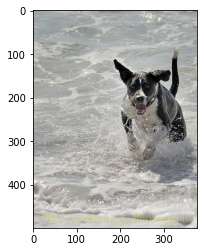

In [ ]:
from random import sample

image_name = sample(train_imgs, 1)[0]
generate_caption(image_name)